<a href="https://colab.research.google.com/github/mrm1404/Style-Transfer-Using-CycleGAN/blob/main/Style_Transfer_Using_CycleGAN_with_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MRI Images Style Transfer Using CycleGAN

This Notebook illustrates MRI Image Conversion from one Type (Tr1) to another MRI type (Tr2) using CycleGAN architecture

**Steps Involved :**
1. Importing Libraries
2. Data Downloading & Loading
3. Data Preprocessing & Visualization
4. Model Building
5. Model Training
6. Generation of an GIF Image

### **1. Importing Libraries**

In [ ]:
## Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob
import cv2
import os
import pandas as pd

### **2. Data Downloading & Loading**

#### **2.1. Data Downloading**

In [ ]:
!wget -q https://github.com/mrm1404/Style-Transfer-Using-CycleGAN/raw/main/Dataset/MRI%2BT1_T2%2BDataset.RAR

#### **2.2. Data Loading**

In [ ]:
## Data Extraction
!unrar x "/content/MRI+T1_T2+Dataset.RAR"

In [ ]:
## Method to get List of Images with different extensions
#### From the Directory path specified
def getImageListFromFolder(folderpath, ext=['png']):
    files = []
    [files.extend(glob.glob(folderpath + '*.' + e)) for e in ext]
    images = []
    if len(files) > 1:
        images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files]
    return images

In [ ]:
## Loading MRI Images into specific MRI type list 
tr1_img_directory = "Tr1/TrainT1/"
tr2_img_directory = "Tr2/TrainT2/"
tr1_images_lst =[]
tr1_images_lst= getImageListFromFolder(tr1_img_directory)
tr2_images_lst= getImageListFromFolder(tr2_img_directory)
print("No of Tr1 MRI Images: ", len(tr1_images_lst))
print("No of Tr2 MRI Images: ", len(tr2_images_lst))

No of Tr1 MRI Images:  43
No of Tr2 MRI Images:  46


### **3. Data Pre-Processing & Visualization**
- Resizing
- Reshaping
- Shuffle and Batch 
- Data Visualization

#### 3.1. Resizing

In [ ]:
## Loading Tr1 Data, Normalization Resizing Images
tr1_data = np.zeros((len(tr1_images_lst), 128, 128))
for index, img in enumerate(tr1_images_lst):
    img = (img/127.5) - 1 #normalization
    resize_img = resize(img, (128,128))
    tr1_data[index,:,:] = resize_img
tr1_data.shape

(43, 128, 128)

In [ ]:
## Loading Tr2 Data, Normalization, Resizing Images
tr2_data = np.zeros((len(tr2_images_lst), 128, 128))
for index, img in enumerate(tr2_images_lst):
    img = (img/127.5) - 1 #normalization
    resize_img = resize(img, (128,128))
    tr2_data[index, :, :] = resize_img
    
tr2_data.shape

(46, 128, 128)

#### 3.2. Reshaping

In [ ]:
## Data Reshaping
tr1_data = tr1_data.reshape(tr1_data.shape[0], 128, 128, 1).astype('float32')
tr2_data = tr2_data.reshape(tr2_data.shape[0], 128, 128, 1).astype('float32')

#### 3.3. Shuffling & Batching

In [ ]:
## Defining Constants
BATCH_SIZE = 5

In [ ]:
## Shuffling the Images and Setting Batch Input Layers
tr1_data = tf.data.Dataset.from_tensor_slices(tr1_data).shuffle(tr1_data[0].shape[0], seed=42).batch(BATCH_SIZE)
tr2_data = tf.data.Dataset.from_tensor_slices(tr2_data).shuffle(tr2_data[0].shape[0], seed=42).batch(BATCH_SIZE)

#### 3.4. Data Visualization

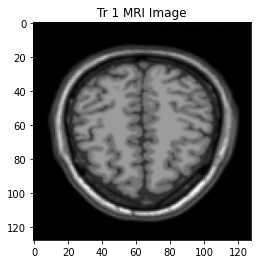

In [ ]:
## Data Visualization of Tr1 Type MRI Image Data
sample_tr1_data = next(iter(tr1_data))
plt.imshow(sample_tr1_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('Tr 1 MRI Image')
plt.axis('on')
plt.show()

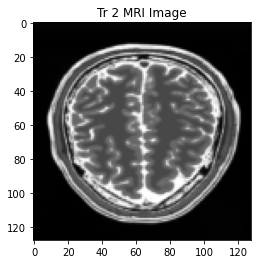

In [ ]:
## Data Visualization of Tr2 Type MRI Image Data
sample_tr2_data = next(iter(tr2_data))
plt.imshow(sample_tr2_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('Tr 2 MRI Image')
plt.axis('on')
plt.show()

### **4. Model Building**
- Instance Normalization
- Downsampling, Upsampling, Unet
- Generator Building
- Discriminator Building

#### 4.1. Instance Normalization
Added to each upsampling layer to perform channelwise Normalization.

In [ ]:
## Instance Normalization to be added to each Upsampling to normalize the Images
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### 4.2. Downsampling
Downsampling is performed to reduce image dimensions.

In [ ]:
## Downsampling Layer
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### 4.3. Upsampling
Upsampling is a result of Transposed Convolution, so that dimension of image are increased.

In [ ]:
## Upsampling Layer
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def averagePool():
    pooling_layer = tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    return pooling_layer

In [ ]:
def maxPool():
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
    return pooling_layer

#### 4.4. Generator Building
Creation of Generator Unet Architecture using Downsampling, Pooling Layers, Upsampling, Transposed Convolution Operations

In [ ]:
## Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(256, 4, False), # (bs, 64, 64, 256)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(256, 4), # (bs, 16, 16, 256)
        maxPool(), # (bs, 8, 8, 256) Max Pooling Applied to add edges details
        downsample(256, 4), # (bs, 4, 4, 256)
        averagePool()       # (bs, 2, 2, 256) Average Pooling Applied to add finer details(ridges lines and white layers)
    ]
    up_stack = [
        upsample(256, 4, True), # (bs, 4, 4, 256)
        upsample(256, 4, True), # (bs, 8, 8, 256)
        upsample(256, 4, True), # (bs, 16, 16, 256)
        upsample(256, 4), # (bs, 32, 32, 256)
        upsample(256, 4) # (bs, 64, 64, 256)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    upscale_last_lyr = upsample(256,4) # (bs, 128, 128, 256)
    last = tf.keras.layers.Conv2DTranspose(1, 7, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    pooling_last_lyr = averagePool() ## (bs, 128,128,1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    ## Upscaling applied at end to add more clarity in Image
    x = upscale_last_lyr(x)
    ## Transposed Convolution adds up layers
    x = last(x)
    ## Average Pooling is added to provide averaging over the final output image
    x = pooling_last_lyr(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
### Generators For Tr1 to Tr2 MRI Image Generation
##Genrator G - Tr1 to Tr2 Conversion
generator_g = unet_generator()
##Genrator F - Tr2 to Tr1 Conversion
generator_f = unet_generator()

#### Generator Layer Summary

In [ ]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 256)  4096        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32, 32, 256)  1049088     sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 16, 16, 256)  1049088     sequential_1[0][0]               
______________________________________________________________________________________________

#### 4.5. Discriminator Building
Discriminator is a traditional CNN, which we use to classify the Images. 

In [ ]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (128, 128, 1)
    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(256, 4, False)(x) # (bs, 64, 64, 256)
    down2 = downsample(256, 4)(down1) # (bs, 32, 32, 256)
    down3 = downsample(256, 4)(down2) # (bs, 16, 16, 512)
    down4 = downsample(512, 4)(down3) # (bs, 8, 8, 512)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 10, 10, 512)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 512)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
#### Discriminators to classify Tr1 and Tr2 MRI Images
## Discriminator x for classifying Tr2 Images
discriminator_x = discriminator()
## Discriminator y for classifying Tr1 Images
discriminator_y = discriminator()

#### Discriminator Layer Summary

In [ ]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 64, 64, 256)       4096      
_________________________________________________________________
sequential_21 (Sequential)   (None, 32, 32, 256)       1049088   
_________________________________________________________________
sequential_22 (Sequential)   (None, 16, 16, 256)       1049088   
_________________________________________________________________
sequential_23 (Sequential)   (None, 8, 8, 512)         2098176   
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 10, 10, 512)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 512)         4194

#### Sample Image Generation Using Generators

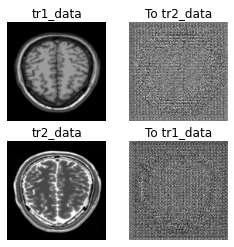

In [ ]:
to_tr1_data = generator_g(sample_tr1_data)
to_tr2_data = generator_f(sample_tr2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_tr1_data, to_tr2_data, sample_tr2_data, to_tr1_data]
title = ['tr1_data', 'To tr2_data', 'tr2_data', 'To tr1_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

### 5. Model Training
- Declare Loss type
- Calculate Discriminator Loss
- Calculate Generator Loss
- Cycle Loss
- Identity Loss
- Optimizer
- Checkpoint Initialization
- Training Flow

#### 5.1. Loss Function Creation

In [ ]:
#### Loss Function for Dicriminator and Generator
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 5.2. Discriminator Loss Function

In [ ]:
#### Method to calculate Discriminator Loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### 5.3. Generator Loss Function

In [ ]:
#### Method to calculate Generator Loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### 5.4. Cycle Loss Function

In [ ]:
#### Method to calculate Cycle Loss
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### 5.5. Identity Loss Function

In [ ]:
#### Method to calculate Identity Loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### 5.6. Define Optimizers for Generator & Discriminator Loss Function

In [ ]:
#### Optimizers for Generators & Discriminators
## Optimizer for Tr1 MRI Image Generator
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
## Optimizer for Tr2 MRI Image Generator
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Optimizer for Tr2 MRI Image Discriminator
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
## Optimizer for Tr1 MRI Image Discriminator
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
#### Setting EPOCHS Training Length
EPOCHS = 5

#### 5.7. Defining Checkpoint Manager to save Model Checkpoints

In [ ]:
#### Checkpoint Manager Definition
## Directory for Saving Model Checkpoints
checkpoint_path = "./Trained_Model"
## Checkpoint Steps Definition
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
## Checkpoint Manager Creation
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
#### Method to generate Plot and Show the Real and Predicted Images at end of every Epochs While Training
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### 5.8. Define Training Flow

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        ### Generator G translates Tr1 -> Tr2
        ### Generator F translates Tr2 -> Tr1
        
        ## fake_y creates predicted Tr2 Image from Tr1 
        fake_y = generator_g(real_x, training=True)
        ## cycled_x creates generated Tr2 Image back to Tr1 
        cycled_x = generator_f(fake_y, training=True)
        
        ## fake_x creates predicted Tr1 Image from Tr2 
        fake_x = generator_f(real_y, training=True)
        ## cycled_y creates generated Tr1 Image back to Tr2 
        cycled_y = generator_g(fake_x, training=True)
        
        ### same_x and same_y are used for identity loss.
        ## same_x creates Tr1 image from real Tr1 image
        same_x = generator_f(real_x, training=True)
        ## same_y creates Tr2 image from real Tr2 image
        same_y = generator_g(real_y, training=True)
        
        ## Discriminator Func to Classify whether Real Tr1 Image is fake or not
        disc_real_x = discriminator_x(real_x, training=True)
        ## Discriminator Func to Classify whether Real Tr2 Image is fake or not
        disc_real_y = discriminator_y(real_y, training=True)
        ### Discriminator Func to Classify whether Generated Tr1 Image is fake or not
        disc_fake_x = discriminator_x(fake_x, training=True)
        ### Discriminator Func to Classify whether Generated Tr2 Image is fake or not
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        ### calculate the generator loss
        ## Generator Loss while generating Tr2 Image from Tr1 Image
        gen_g_loss = generator_loss(disc_fake_y)
        ## Generator Loss while generating Tr1 Image from Tr2 Image
        gen_f_loss = generator_loss(disc_fake_x)
        
        ### calculation of cycle loss that is loss occurred while conversion from Tr1 > Tr2 > Tr1 & Tr2 > Tr1 > Tr2
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        ### Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        ### Total Discriminator's loss
        ## Discriminator Loss While Classifying Tr1 Images
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        ## Discriminator Loss While Classifying Tr2 Images
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    #### Calculate the gradients for generator and discriminator
    ## Gradient Loss For Generation of Tr1 to Tr2 Image Conversion
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    ## Gradient Loss For Generation of Tr2 to Tr1 Image Conversion
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    ## Gradient Loss For Classification of Tr1 Image
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    ## Gradient Loss For Classification of Tr2 Image
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    ### Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

### Begin Training Flow

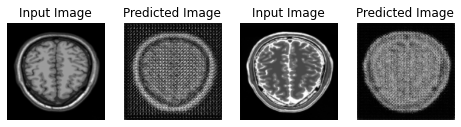

Saving checkpoint for epoch 1 at ./Trained_Model\ckpt-1


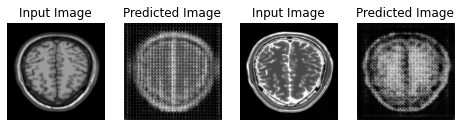

Saving checkpoint for epoch 2 at ./Trained_Model\ckpt-2


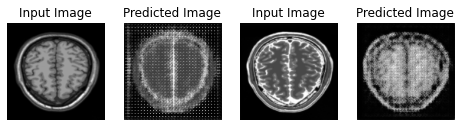

Saving checkpoint for epoch 3 at ./Trained_Model\ckpt-3


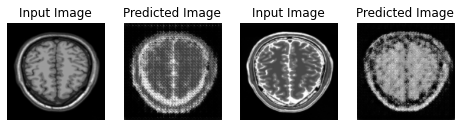

Saving checkpoint for epoch 4 at ./Trained_Model\ckpt-4


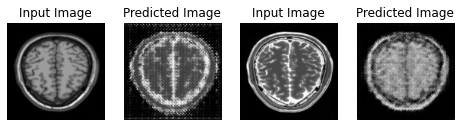

Saving checkpoint for epoch 5 at ./Trained_Model\ckpt-5


In [ ]:
### Training Flow Set 1
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1_data, tr2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1_data, generator_f, sample_tr2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

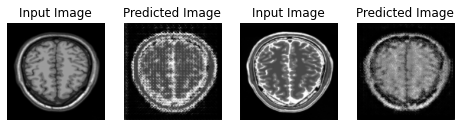

Saving checkpoint for epoch 6 at ./Trained_Model\ckpt-6


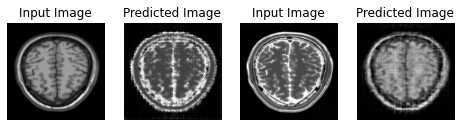

Saving checkpoint for epoch 7 at ./Trained_Model\ckpt-7


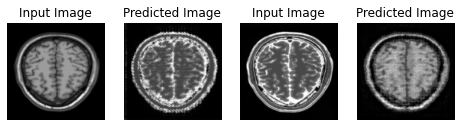

Saving checkpoint for epoch 8 at ./Trained_Model\ckpt-8


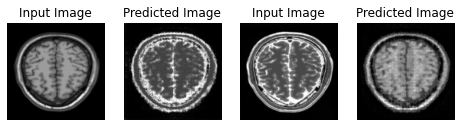

Saving checkpoint for epoch 9 at ./Trained_Model\ckpt-9


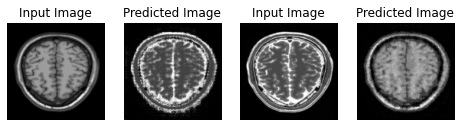

Saving checkpoint for epoch 10 at ./Trained_Model\ckpt-10


In [ ]:
### Training Flow Set 2
for epoch in range(6, (2*EPOCHS)+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1_data, tr2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1_data, generator_f, sample_tr2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

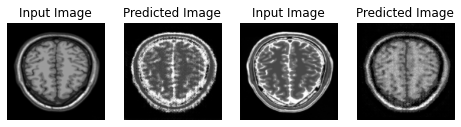

Saving checkpoint for epoch 11 at ./Trained_Model\ckpt-11


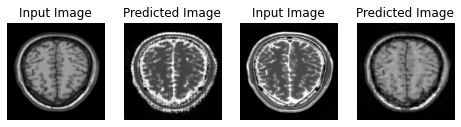

Saving checkpoint for epoch 12 at ./Trained_Model\ckpt-12


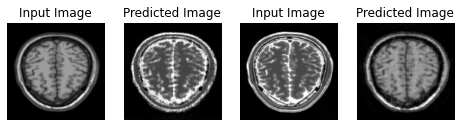

Saving checkpoint for epoch 13 at ./Trained_Model\ckpt-13


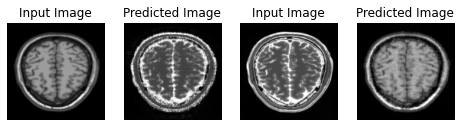

Saving checkpoint for epoch 14 at ./Trained_Model\ckpt-14


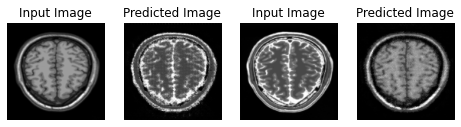

Saving checkpoint for epoch 15 at ./Trained_Model\ckpt-15


In [ ]:
### Training Flow Set 3
for epoch in range(11, (3*EPOCHS)+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1_data, tr2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1_data, generator_f, sample_tr2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

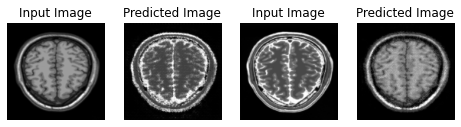

Saving checkpoint for epoch 16 at ./Trained_Model\ckpt-16


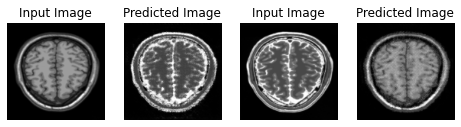

Saving checkpoint for epoch 17 at ./Trained_Model\ckpt-17


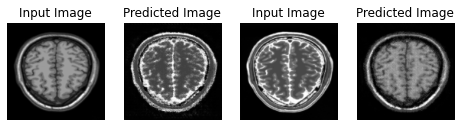

Saving checkpoint for epoch 18 at ./Trained_Model\ckpt-18


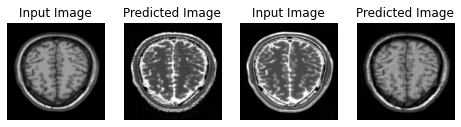

Saving checkpoint for epoch 19 at ./Trained_Model\ckpt-19


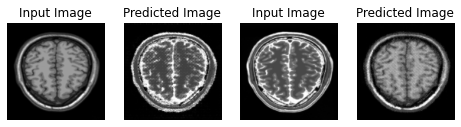

Saving checkpoint for epoch 20 at ./Trained_Model\ckpt-20


In [ ]:
### Training Flow Set 4
for epoch in range(16, (4*EPOCHS)+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1_data, tr2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1_data, generator_f, sample_tr2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

> ### At Epoch 20, the MRI Image has converted perfectly from Tr 1 type to Tr 2 Type. Hence Creating gif file till 20th Epoch File

### 6. Generating a GIF for visualization of Results

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\madhavm3\appdata\local\temp\pip-req-build-ocy8ghhe
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\MadhavM3\AppData\Local\Temp\pip-req-build-ocy8ghhe'



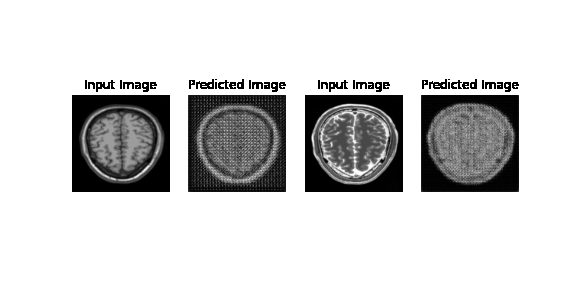

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)